In [1]:
import pickle
with open('paper_author_vectors.pkl', 'rb') as f:
    vector_data = pickle.load(f)

# This code defines a PyTorch Dataset class to handle influencer data for model training.

**Purpose:**
- Wraps a dictionary of paper data into a PyTorch `Dataset` for easy batching and loading.
- Converts one-hot vectors, multi-hot vectors, and fairness scores into PyTorch tensors.
- Facilitates training by enabling DataLoader usage.



In [2]:
import pickle
import torch
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class InfluencerDataset(Dataset):
    def __init__(self, data_dict):
        self.data = []
        for v in data_dict.values():
            item = {
                'one_hot': torch.tensor(v['one_hot'], dtype=torch.float),
                'multi_hot': torch.tensor(v['multi_hot'], dtype=torch.float),
                'fairness': torch.tensor([v['fairness']], dtype=torch.float)  # float -> shape [1]
            }
            self.data.append(item)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (
            self.data[idx]['one_hot'],
            self.data[idx]['multi_hot'],
            self.data[idx]['fairness']
        )


# Downsamples the influence (multi-hot vector) of each paper based on its fairness score.

**Purpose:**
- Reduces the number of influenced authors (non-zero entries in `multi_hot`) for each paper proportionally to its fairness score.
- Simulates fairness-aware influence modeling.


In [3]:
import random
import torch

def simple_downsample_by_fairness(dataset):
    downsample_log = {}

    for idx, item in enumerate(dataset.data):
        fairness_score = float(item['fairness'].item())  # ensure float
        multi_hot = item['multi_hot']

        influenced_indices = (multi_hot == 1).nonzero(as_tuple=True)[0].tolist()
        total_influenced = len(influenced_indices)

        downsample_log[idx] = {
            'before': total_influenced,
            'fairness': fairness_score
        }

        if total_influenced == 0:
            downsample_log[idx]['after'] = 0
            continue

        num_to_keep = max(1, int(fairness_score * total_influenced))  # ensure at least 1 if >0
        num_to_keep = min(num_to_keep, total_influenced)  # don't exceed available

        indices_to_keep = random.sample(influenced_indices, num_to_keep)
        new_multi_hot = torch.zeros_like(multi_hot)
        new_multi_hot[indices_to_keep] = 1

        item['multi_hot'] = new_multi_hot
        downsample_log[idx]['after'] = len(indices_to_keep)

    return downsample_log


# Fair2VecMTL — A Multi-Task Learning Model for Influence and Fairness Prediction

**Purpose:**
This model is designed to learn a shared representation from one-hot encoded inputs and simultaneously:
1. Predict influenced members via multi-label classification.
2. Predict a fairness score via regression.
3. Provide influencer embeddings for downstream tasks.

**Architecture Overview:**
- **Input:** One-hot vector representing a paper (or node).
- **Shared Layer:** Projects input into a 50-dimensional latent space using a linear layer followed by ReLU.
- **Influence Head:** Predicts a multi-hot vector indicating influenced authors using a sigmoid-activated linear layer.
- **Fairness Head:** Outputs a scalar fairness score using a regression head (linear layer, no activation).
- **Embedding Output:** Intermediate shared representation (`influencer_embedding`) that can be used for further tasks.

**Forward Pass:**
- Applies shared transformation (`linear` + `ReLU`).
- Feeds into:
  - `influence_head` → sigmoid → multi-label prediction
  - `fairness_head` → regression output
- Also returns the shared embedding (`influencer_embedding`) for flexibility.

**Output:**
- `pred_influence`: Tensor of shape `[batch_size, num_targets]`
- `pred_fairness`: Tensor of shape `[batch_size, 1]`
- `influencer_embedding`: Tensor of shape `[batch_size, 50]`


In [4]:
class Fair2VecMTL(nn.Module):
    def __init__(self, input_dim, num_targets):
        super(Fair2VecMTL, self).__init__()

        # Linear projection from one-hot to embedding-like space (optional)
        self.linear = nn.Linear(input_dim, 50)  # Shared first layer

        # Separate layers for influencer and influenced members
        # self.influencer_head = nn.Linear(50, 50)  # For influencer embedding
        self.influence_head = nn.Linear(50, num_targets)  # Multi-label classification for influence
        self.fairness_head = nn.Linear(50, 1)  # Regression for fairness

    def forward(self, x):
        # Shared layer
        x_shared = F.relu(self.linear(x))

        # Influencer embedding (first hidden layer)
        influencer_embedding = F.relu(x_shared)

        # Prediction for influencer (binary classification)
        pred_influence = torch.sigmoid(self.influence_head(influencer_embedding))

        # Fairness prediction (regression)
        pred_fairness = self.fairness_head(x_shared)

        return pred_influence, pred_fairness, influencer_embedding

# fair2vec_loss — Custom Loss Function for Fair2VecMTL

**Purpose:**
Combines binary cross-entropy loss (for influence prediction) and mean squared error loss (for fairness prediction) to train the Fair2Vec multi-task learning model.

**Loss Components:**
1. **Binary Cross-Entropy (BCE) Loss:**
   - Measures how well the model predicts the influenced members (multi-label classification).

2. **Mean Squared Error (MSE) Loss:**
   - Measures the error between the predicted and true fairness scores (regression task).

**Return Value:**
- The **sum** of BCE and MSE losses.



In [5]:
def fair2vec_loss(pred_influence, true_influence, pred_fairness, true_fairness):
    bce_loss = F.binary_cross_entropy(pred_influence, true_influence)
    mse_loss = F.mse_loss(pred_fairness, true_fairness)
    # reg_loss = lambda_reg * torch.norm(embedding, p=2)
    return bce_loss + mse_loss

# Training Setup and Downsampling — Fair2Vec MTL



In [6]:
# Hyperparameters
num_users = len(vector_data[list(vector_data.keys())[0]]['one_hot'])
num_targets = len(vector_data[list(vector_data.keys())[0]]['multi_hot'])
batch_size = 100
num_epochs = 200
learning_rate = 0.001

# Dataset and loader
dataset = InfluencerDataset(vector_data)
print(type(dataset))
# Check the format by inspecting a single sample
sample = dataset[0]
# print(f"Sample format: {sample}")
print(sample[0].shape)
print(sample[1].shape)
downsample_info = simple_downsample_by_fairness(dataset)

# Save influence count before and after downsampling
influencer_counts = {}

# Original count: from vector_data
for idx, item in enumerate(dataset):
    infl_id = list(vector_data.keys())[idx]
    original_count = int(np.sum(vector_data[infl_id]['multi_hot']))
    downsampled_count = downsample_info[idx]['after'] if idx in downsample_info else original_count
    fairness = downsample_info[idx]['fairness'].item() if isinstance(downsample_info[idx]['fairness'], torch.Tensor) else downsample_info[idx]['fairness']

    influencer_counts[infl_id] = {
        'original_count': original_count,
        'downsampled_count': downsampled_count,
        'fairness': fairness
    }

# # Optional: Save to file
# import pickle
# with open("influence_counts_before_after.pkl", "wb") as f:
#     pickle.dump(influencer_counts, f)

# print("Saved influence counts before and after downsampling.")


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model and optimizer
model = Fair2VecMTL(input_dim=num_users, num_targets=num_targets)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

<class '__main__.InfluencerDataset'>
torch.Size([5897])
torch.Size([71532])
Fair2VecMTL(
  (linear): Linear(in_features=5897, out_features=50, bias=True)
  (influence_head): Linear(in_features=50, out_features=71532, bias=True)
  (fairness_head): Linear(in_features=50, out_features=1, bias=True)
)


In [7]:
num_users = len(vector_data[list(vector_data.keys())[0]]['one_hot'])
num_targets = len(vector_data[list(vector_data.keys())[0]]['multi_hot'])
batch_size = 100
num_epochs = 200
learning_rate = 0.001
for epoch in range(num_epochs):
    total_loss = 0.0
    for one_hot_input, multi_hot_label, true_fairness in dataloader:
        
        # Forward pass
        pred_influence, pred_fairness, influencer_embedding = model(one_hot_input)

        # Losses
        bce_loss = F.binary_cross_entropy(pred_influence, multi_hot_label)
        mse_loss = F.mse_loss(pred_fairness, true_fairness)
        loss = bce_loss + mse_loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Output for each epoch
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    # This one prints the total loss over all batches
    print(f"Average Loss: {total_loss:.4f}")


Epoch 1/200
Average Loss: 49.9819

Epoch 2/200
Average Loss: 36.5221

Epoch 3/200
Average Loss: 27.5990

Epoch 4/200
Average Loss: 19.4623

Epoch 5/200
Average Loss: 14.2433

Epoch 6/200
Average Loss: 11.4160

Epoch 7/200
Average Loss: 9.6540

Epoch 8/200
Average Loss: 8.4700

Epoch 9/200
Average Loss: 7.7847

Epoch 10/200
Average Loss: 7.4278

Epoch 11/200
Average Loss: 7.2141

Epoch 12/200
Average Loss: 7.0553

Epoch 13/200
Average Loss: 6.9216

Epoch 14/200
Average Loss: 6.7979

Epoch 15/200
Average Loss: 6.6748

Epoch 16/200
Average Loss: 6.5462

Epoch 17/200
Average Loss: 6.4097

Epoch 18/200
Average Loss: 6.2691

Epoch 19/200
Average Loss: 6.1291

Epoch 20/200
Average Loss: 5.9920

Epoch 21/200
Average Loss: 5.8647

Epoch 22/200
Average Loss: 5.7447

Epoch 23/200
Average Loss: 5.6291

Epoch 24/200
Average Loss: 5.5172

Epoch 25/200
Average Loss: 5.4120

Epoch 26/200
Average Loss: 5.3165

Epoch 27/200
Average Loss: 5.2308

Epoch 28/200
Average Loss: 5.1540

Epoch 29/200
Average L

# Influence Count Extraction Script

**Purpose:**
This script calculates the number of influenced authors for each paper ID from the `id_to_id_author_mapping.pkl` file and stores the result in a pickle file named `influence_counts_before_after.pkl`.



## Influencer Embedding Statistics Script

Compute embedding norms and influence metrics for each influencer using the trained `Fair2VecMTL` model.

- Saves the list as `influencer_stats.pkl`.


In [8]:
print("\n=== Influencer Embedding Norms and Influence Count ===\n")
model.eval()

influencer_stats = []

with torch.no_grad():
    for i, (influencer_id, _) in enumerate(vector_data.items()):
        one_hot_tensor = dataset.data[i]['one_hot'].unsqueeze(0)  # shape: [1, input_dim]
        true_fairness = dataset.data[i]['fairness']
        multi_hot = dataset.data[i]['multi_hot']
        
        # Forward pass
        pred_influence, pred_fairness, influencer_embedding = model(one_hot_tensor)

        # Embedding norms
        embedding_vector = influencer_embedding.squeeze(0)
        l1_norm = torch.norm(embedding_vector, p=1).item()
        l2_norm = torch.norm(embedding_vector, p=2).item()

        # Use updated multi_hot
        influence_count = int(multi_hot.sum().item())

        # influence_embedding 

        influencer_stats.append({
            'influencer_id': influencer_id,
            'l1_norm': l1_norm,
            'l2_norm': l2_norm,
            'influence_count': influence_count,
            'true_fairness': true_fairness.item(),
            'predicted_fairness': pred_fairness.item(),
            'embedding_vector': embedding_vector
        })


import pickle

# Save influencer_stats to a pickle file
with open("influencer_stats.pkl", "wb") as f:
    pickle.dump(influencer_stats, f)

print("influencer_stats saved to 'influencer_stats.pkl'")


=== Influencer Embedding Norms and Influence Count ===

influencer_stats saved to 'influencer_stats.pkl'


In [9]:
# # Load the embeddings and predicted stats
# with open("influencer_stats.pkl", "rb") as f:
#     influencer_stats = pickle.load(f)

# Plot of original influencer count
- Saves the plot as `original_influencer_count.png`

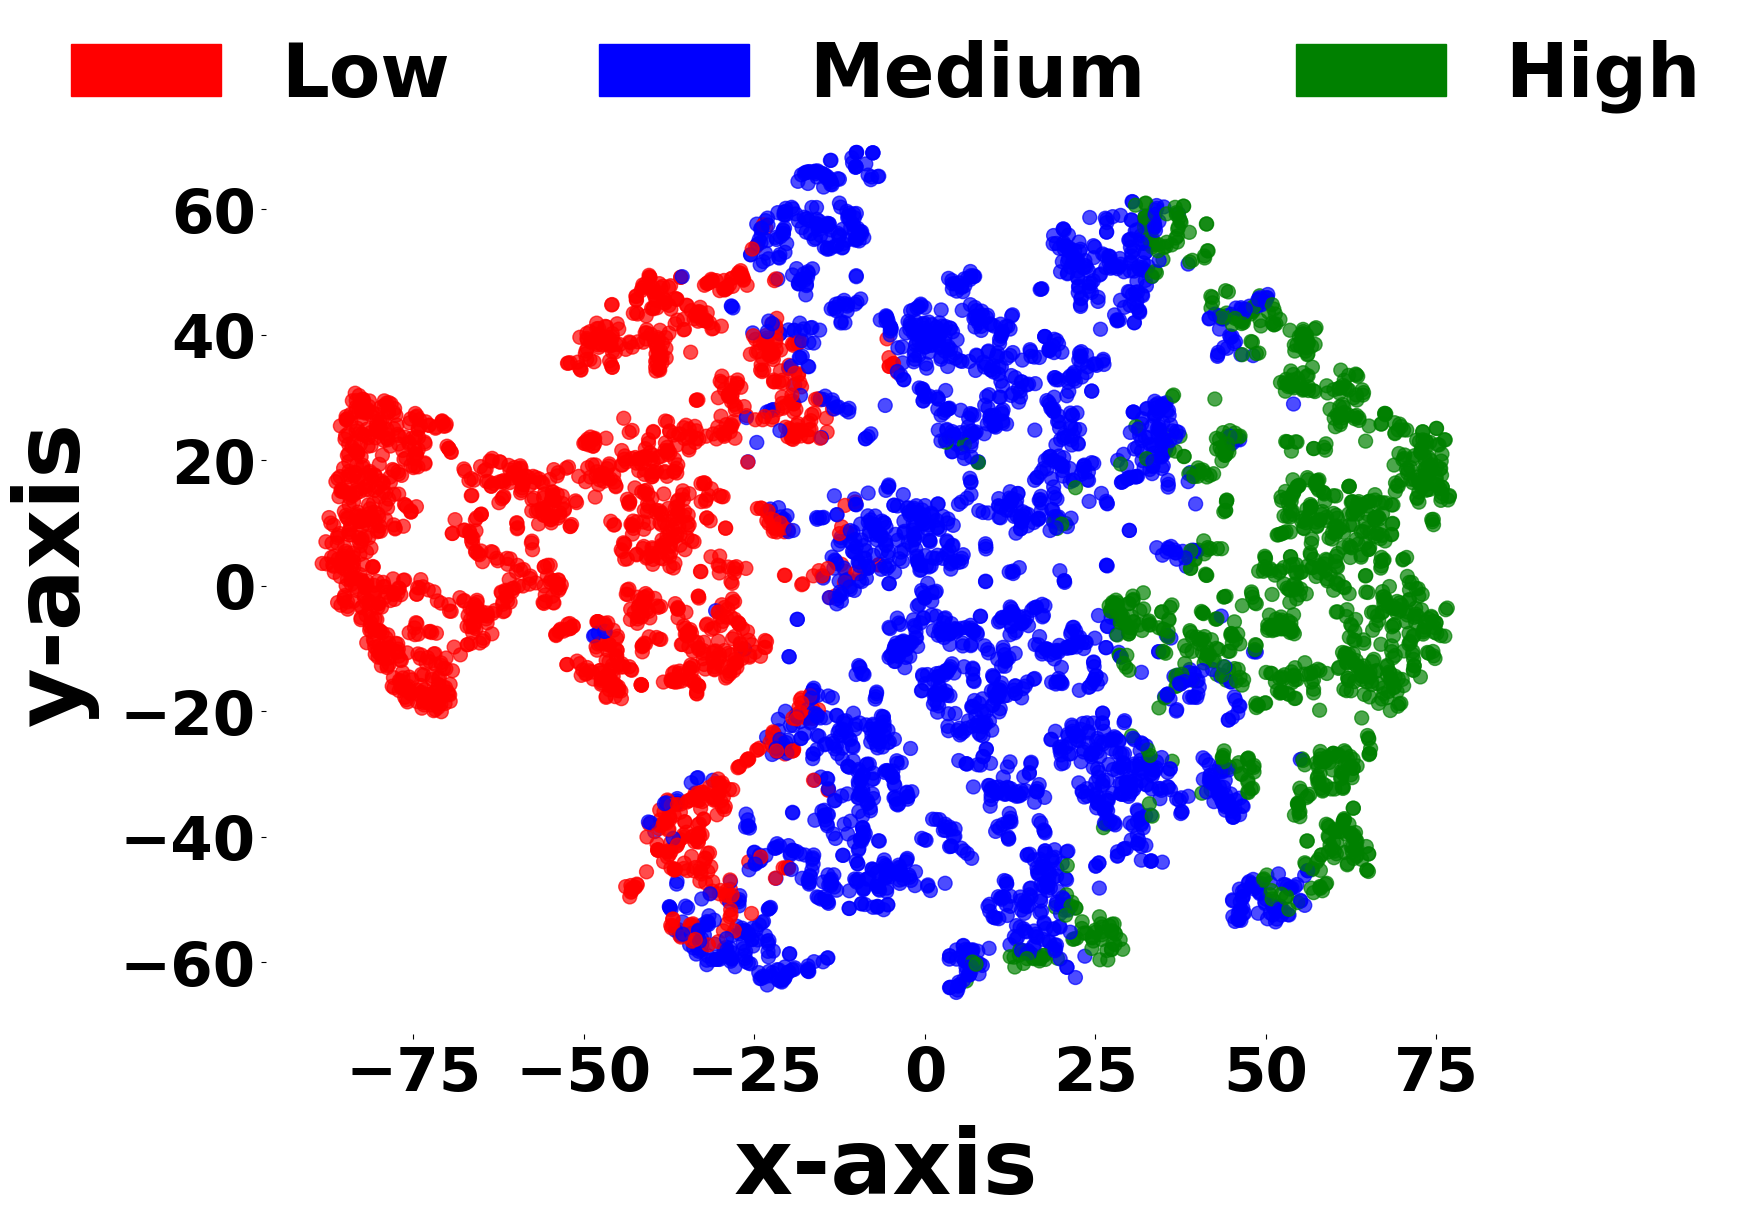

In [10]:
import pickle
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import matplotlib.patches as mpatches

# Load the embeddings and predicted stats
with open("influencer_stats.pkl", "rb") as f:
    influencer_stats = pickle.load(f)

# Load the original and downsampled influence counts
with open("influence_counts_before_after.pkl", "rb") as f:
    influence_count_data = pickle.load(f)

# Prepare embedding vectors and original influence counts
embedding_vectors = []
original_counts = []

for entry in influencer_stats:
    influencer_id = entry['influencer_id']
    embedding = entry['embedding_vector']
    embedding_vectors.append(embedding if isinstance(embedding, torch.Tensor) else torch.tensor(embedding))

    # Correctly access original count if value is a tuple
    if influencer_id in influence_count_data:
        original_counts.append(influence_count_data[influencer_id])
    else:
        original_counts.append(0)  # fallback if missing


# Convert to numpy arrays
embedding_vectors = torch.stack(embedding_vectors).numpy()
original_counts = np.array(original_counts)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(embedding_vectors)

# Assign colors based on original influence count
colors = []
for count in original_counts:
    if count < 3000:
        colors.append("red")
    elif count < 10000:
        colors.append("blue")
    else:
        colors.append("green")

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Plot the t-SNE result
plt.figure(figsize=(16, 12))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, alpha=0.7, s=100)


# Axis labels in bold and large
plt.xlabel("x-axis", fontsize=66, fontweight='bold', labelpad=15)
plt.ylabel("y-axis", fontsize=66, fontweight='bold', labelpad=15)

# Bold and large tick labels
plt.xticks(fontsize=44, fontweight='bold')
plt.yticks(fontsize=44, fontweight='bold')

# Remove grid and spines
plt.grid(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Custom legend patches with larger size and bold labels
legend_patches = [
    mpatches.Patch(color='red', label='Low'),
    mpatches.Patch(color='blue', label='Medium'),
    mpatches.Patch(color='green', label='High'),
]

# Render legend above the plot with bold, large font
legend = plt.legend(
    handles=legend_patches,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    frameon=False,
    fontsize=54
)
for text in legend.get_texts():
    text.set_fontweight('bold')

# Save and show plot
plt.savefig("original_influencer_count.png", dpi=300, bbox_inches='tight')
plt.show()



# Plot of embedding influncer count
- Saves the plot as `embedding_influncer_count.png`

Low Count:  3382
Middle Count:  2148
High Count:  367


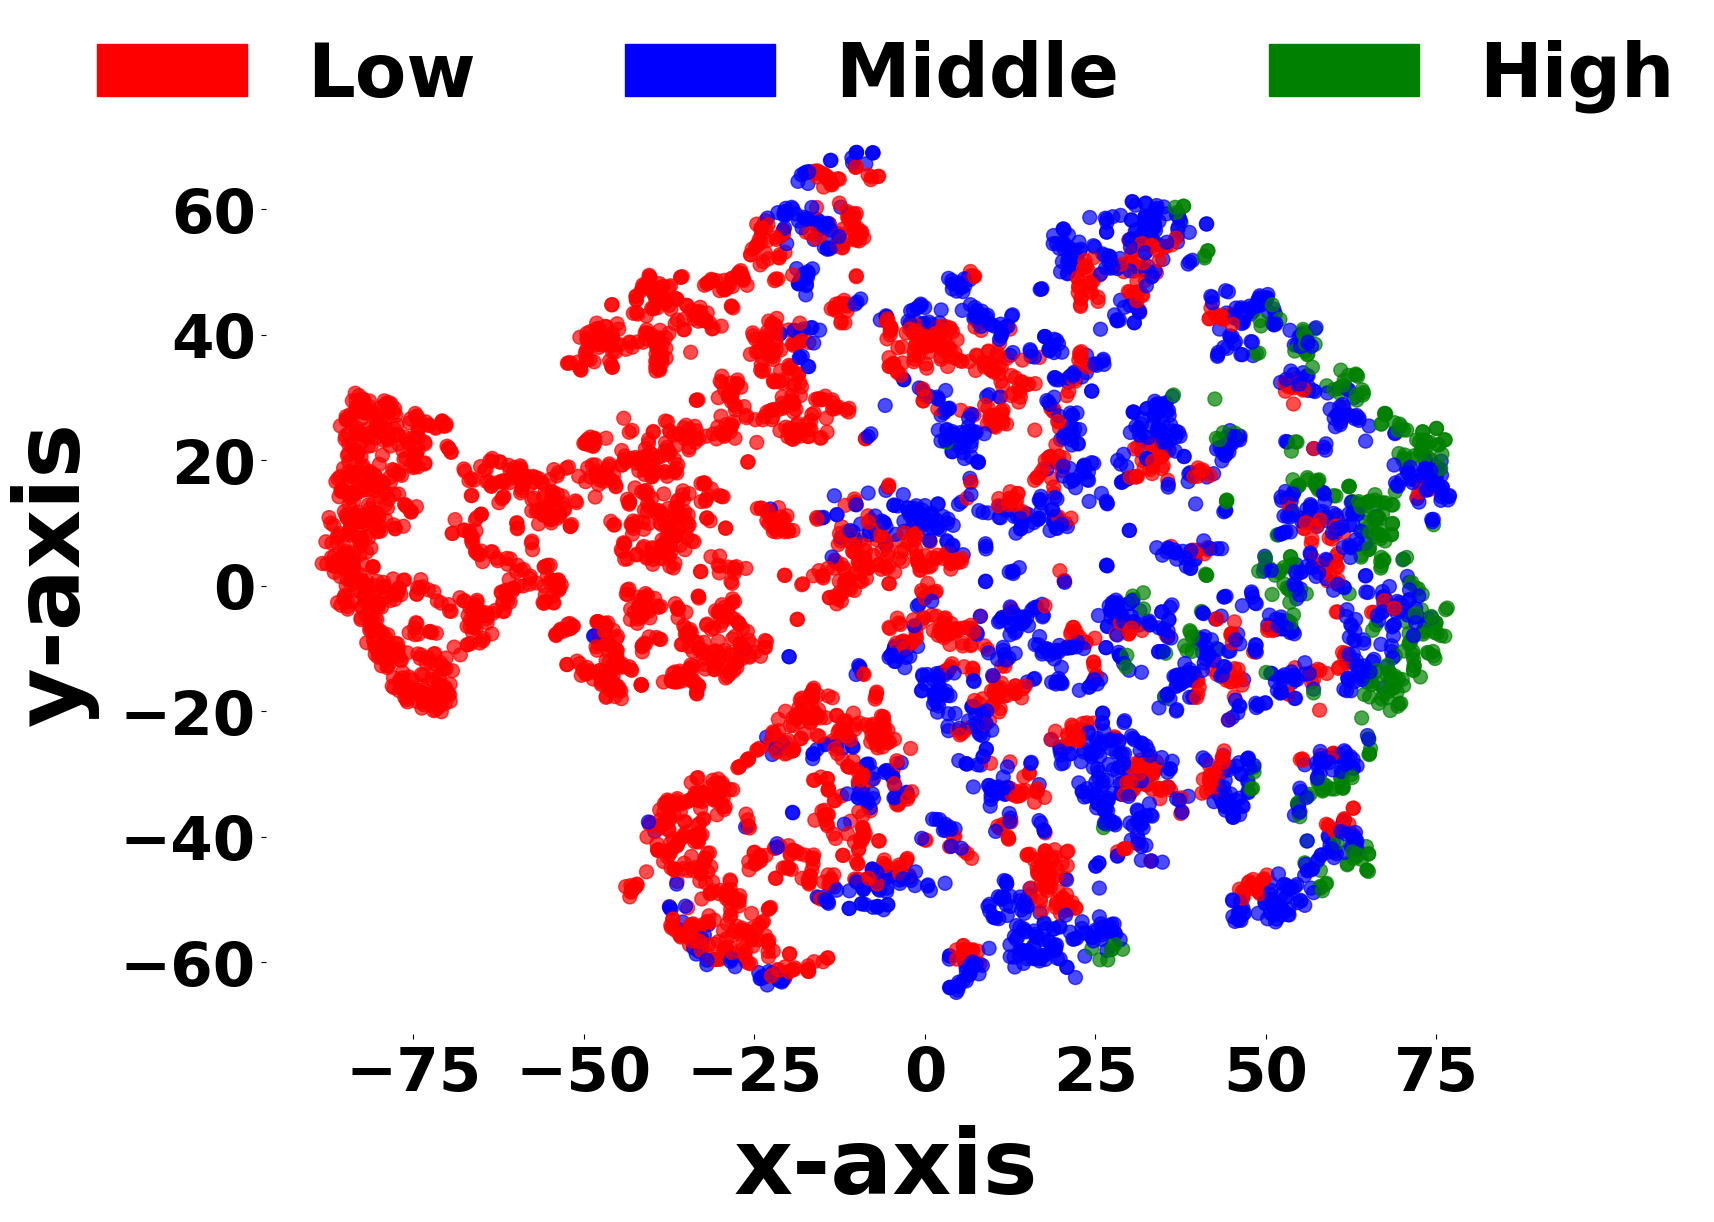

In [11]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert embedding_vectors (list of PyTorch tensors or lists) to a 2D NumPy array
embedding_vectors = np.array([entry['embedding_vector'] for entry in influencer_stats])
influence_counts = [entry['influence_count'] for entry in influencer_stats]

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(embedding_vectors)

# Assign colors based on influence count
colors = []
low_count = 0
middle_count = 0
high_count = 0
for count in influence_counts:
    if count <3000:
        low_count += 1
        colors.append("red")        # Low influence
    elif count < 10000:
        middle_count += 1
        colors.append("blue")       # Middle influence
    else:
        high_count += 1
        colors.append("green")      # High influence

print(f"Low Count: ", low_count)
print(f"Middle Count: ", middle_count)
print(f"High Count: ", high_count)


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create the plot
plt.figure(figsize=(16, 12))

# Scatter plot
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, alpha=0.7, s=100)

# Axis labels in bold and larger font
plt.xlabel("x-axis", fontsize=66, fontweight='bold', labelpad=15)
plt.ylabel("y-axis", fontsize=66, fontweight='bold', labelpad=15)

# Tick labels in bold and larger font
plt.xticks(fontsize=44, fontweight='bold')
plt.yticks(fontsize=44, fontweight='bold')


# Remove grid and axis box (spines)
plt.grid(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Custom legend with bold and larger labels
legend_patches = [
    mpatches.Patch(color='red', label='Low'),
    mpatches.Patch(color='blue', label='Middle'),
    mpatches.Patch(color='green', label='High'),
]

legend = plt.legend(
    handles=legend_patches,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    frameon=False,
    fontsize=54
)
for text in legend.get_texts():
    text.set_fontweight('bold')

# Save and display
plt.savefig("embedding_influncer_count.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot of fairness plot
- Saves the plot as `fairness_plot.png`

Low Fairness: 3256
Middle Fairness: 1628
High Fairness: 1013


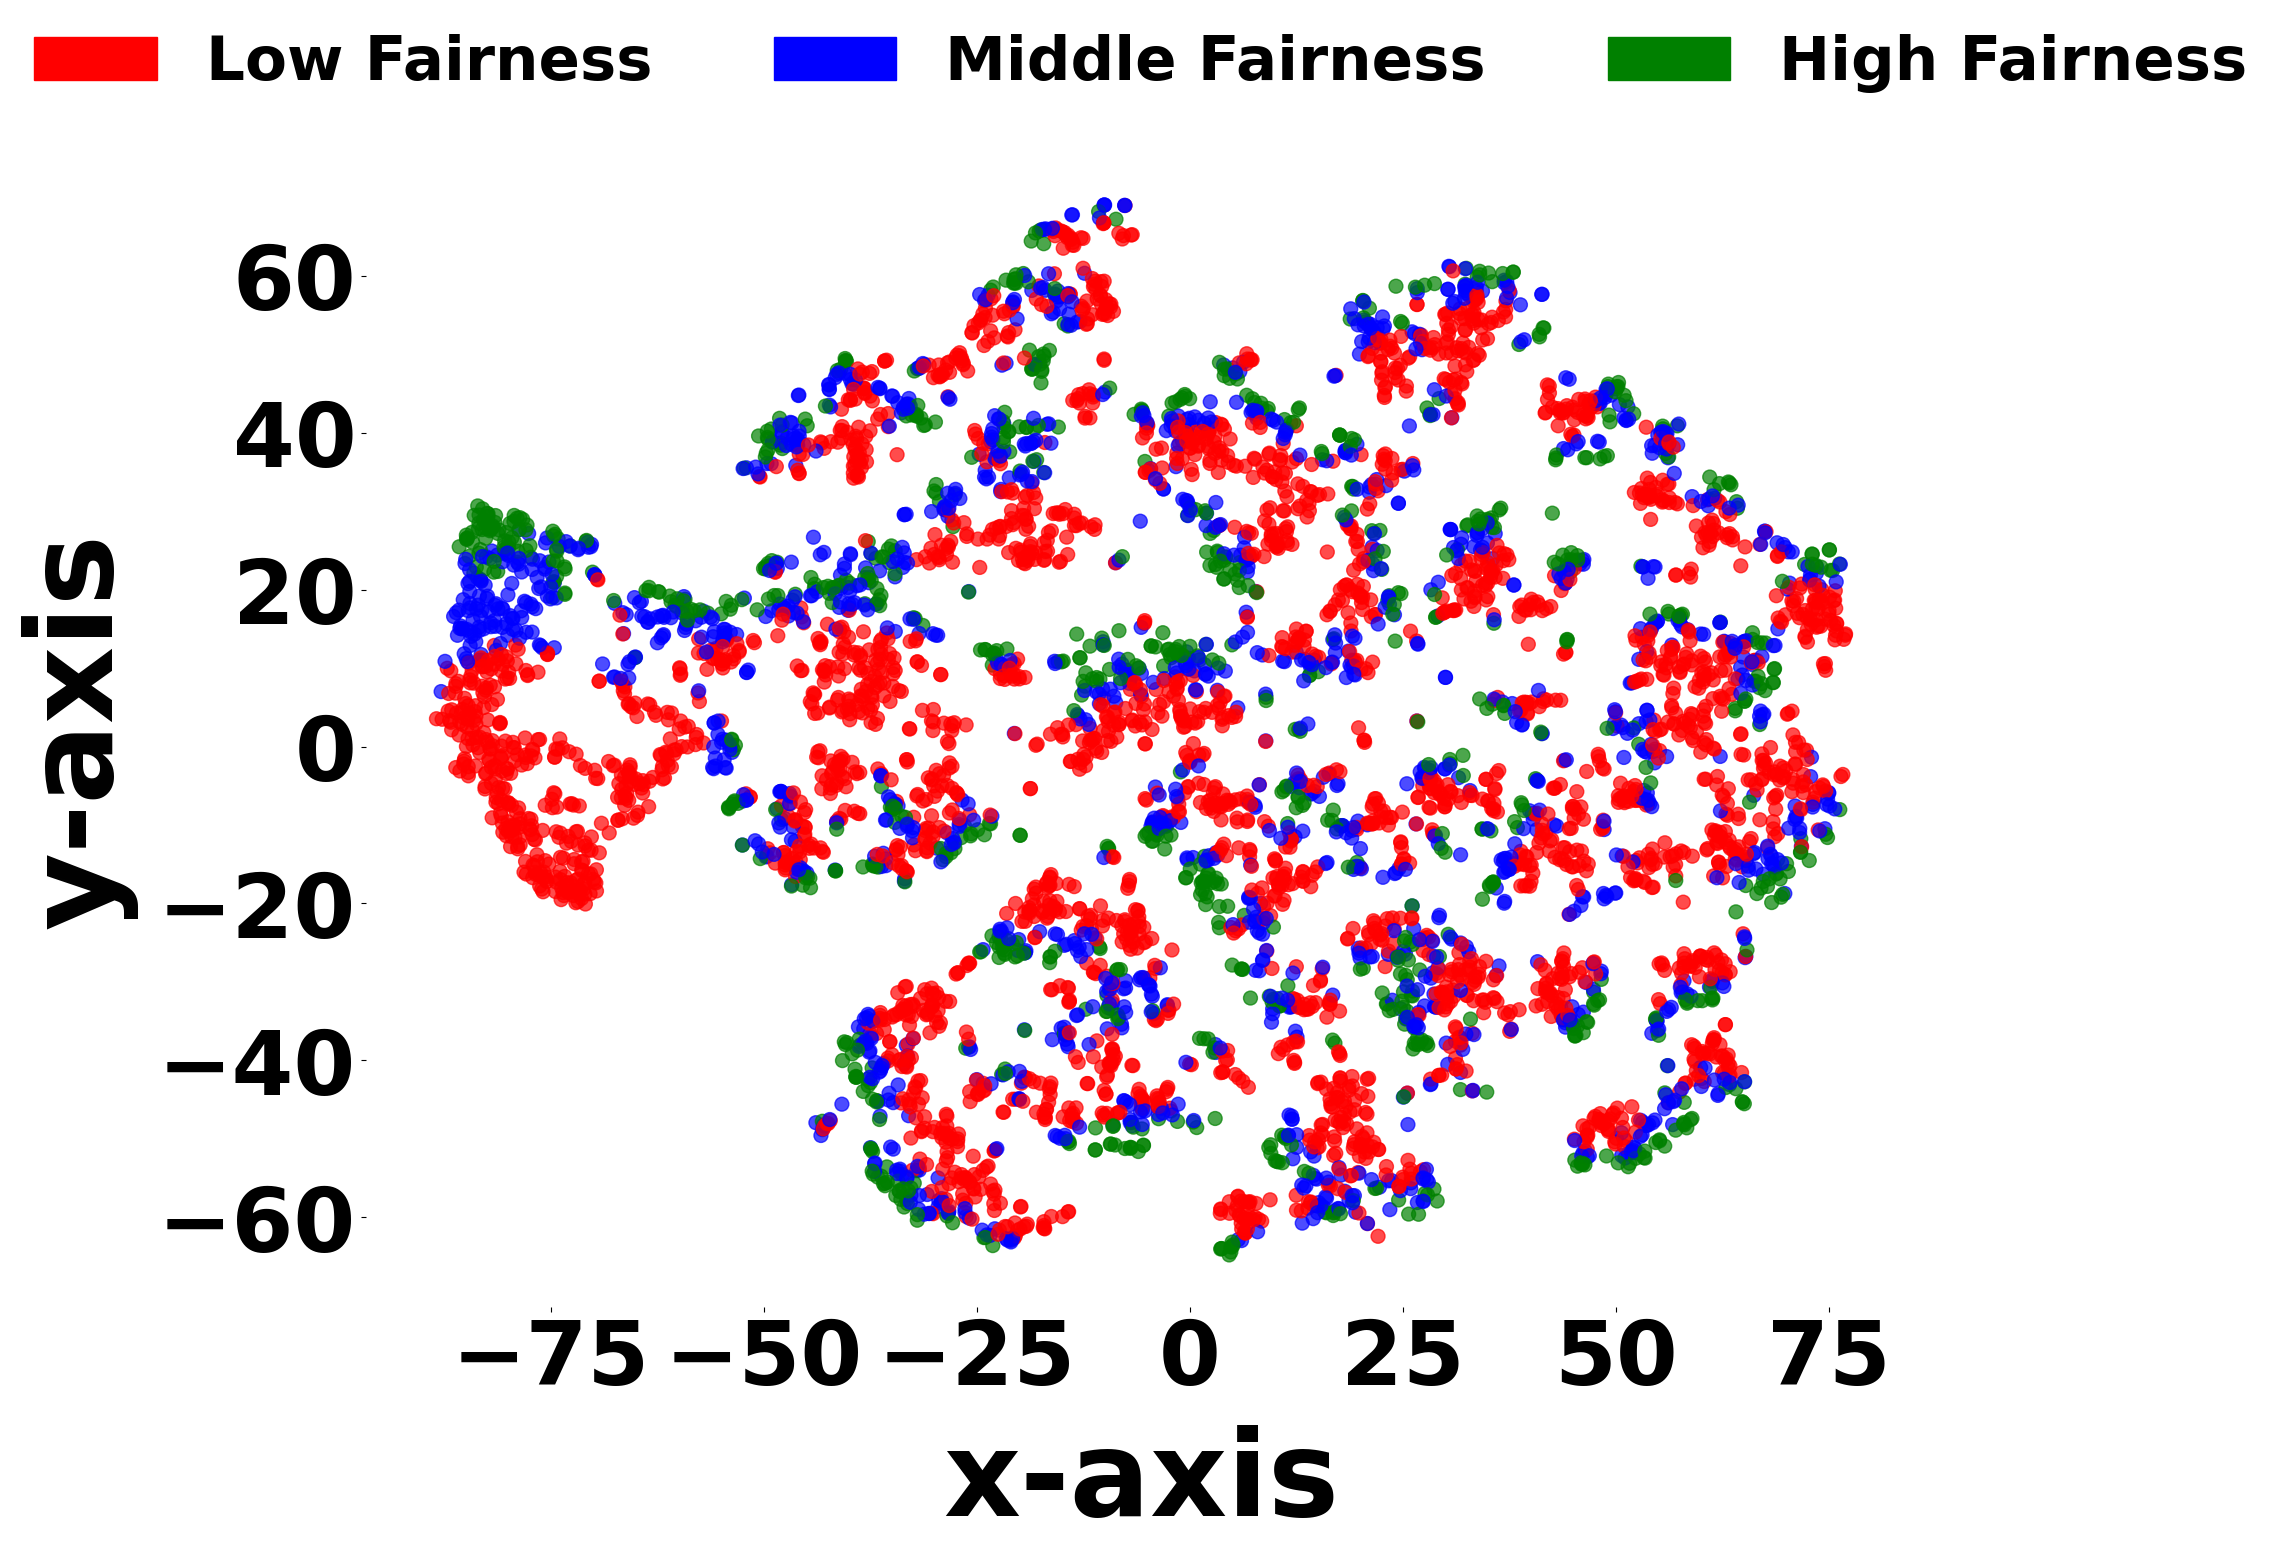

In [16]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Convert embeddings to numpy array
embedding_vectors = np.array([entry['embedding_vector'] for entry in influencer_stats])
fairness_scores = [entry['true_fairness'] for entry in influencer_stats]

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(embedding_vectors)

# Assign colors based on fairness score
colors = []
low_count = 0
middle_count = 0
high_count = 0
for score in fairness_scores:
    if score <= 0.6:
        colors.append("red")
        low_count += 1
    elif score <= 0.85:
        colors.append("blue")
        middle_count += 1
    else:
        colors.append("green")
        high_count += 1

print(f"Low Fairness: {low_count}")
print(f"Middle Fairness: {middle_count}")
print(f"High Fairness: {high_count}")

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Plot the t-SNE result
plt.figure(figsize=(20, 15))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, alpha=.7, s=100)


# Axis labels in bold and large
plt.xlabel("x-axis", fontsize=86, fontweight='bold', labelpad=15)
plt.ylabel("y-axis", fontsize=86, fontweight='bold', labelpad=15)

# Bold and large tick labels
plt.xticks(fontsize=64, fontweight='bold')
plt.yticks(fontsize=64, fontweight='bold')

# Remove grid and spines
plt.grid(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Custom legend patches with larger size and bold labels
legend_patches = [
    mpatches.Patch(color='red', label='Low Fairness'),
    mpatches.Patch(color='blue', label='Middle Fairness'),
    mpatches.Patch(color='green', label='High Fairness')
]

# Render legend above the plot with bold, large font
legend = plt.legend(
    handles=legend_patches,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    frameon=False,
    fontsize=44
)
for text in legend.get_texts():
    text.set_fontweight('bold')

# Save and show plot
plt.savefig("fairness_plot.png", dpi=300, bbox_inches='tight')
plt.show()

## Analyze Top Influencers by Influence Count

1. Load `influencer_stats.pkl`.
2. Sort entries by `influence_count` (descending).
3. Print each influencer's:
   - `ID`, `L1`, `L2` norm
   - `Influence Count`
   - `True` vs `Predicted Fairness`

**Output:**  
Printed top influencers with embedding stats and fairness scores.


In [2]:
import pickle
with open("influencer_stats.pkl", "rb") as f:
    loaded_stats = pickle.load(f)

# Sort by L1 norm (descending)
sorted_by_l1 = sorted(loaded_stats, key=lambda x: x['l1_norm'], reverse=True)

print("\n🔝 Top Influencers by L1 Norm:\n")
for entry in sorted_by_l1[:5]:
    print(f"ID: {entry['influencer_id']}, L1: {entry['l1_norm']:.4f}, L2: {entry['l2_norm']:.4f}, Influence Count: {entry['influence_count']},")
    print(f"True Fairness: {entry['true_fairness']:.4f}, Predicted Fairness: {entry['predicted_fairness']:.4f}\n")


🔝 Top Influencers by L1 Norm:

ID: 2278, L1: 25.8555, L2: 4.9192, Influence Count: 4292,
True Fairness: 0.9859, Predicted Fairness: 0.9930

ID: 912, L1: 25.4941, L2: 4.9348, Influence Count: 3092,
True Fairness: 0.7412, Predicted Fairness: 0.7452

ID: 1352, L1: 25.4292, L2: 4.9565, Influence Count: 3057,
True Fairness: 0.7299, Predicted Fairness: 0.7370

ID: 41, L1: 25.4271, L2: 4.8740, Influence Count: 7128,
True Fairness: 0.9864, Predicted Fairness: 1.0030

ID: 339, L1: 25.3797, L2: 4.8470, Influence Count: 3332,
True Fairness: 0.7994, Predicted Fairness: 0.8033

